In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2023-03-27 15:33:47.963263: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 15:33:48.544375: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.12.0


In [2]:
physical_devices = tf.config.list_physical_devices("GPU")
print(*physical_devices)

for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [56]:
dfs = []
for m in tqdm(np.arange(0.8, 1.22, 0.02)):
    df = pd.read_hdf("/var/local/Scratch/shared/data/mesa_grids/grid2p5a/grid.h5", key=f"m{m:.2f}")
#     df = df.loc[np.isclose(df.initial_Yinit, 0.28) & np.isclose(df.initial_MLT, 1.9)]
    dfs.append(df)
#     break
    
df = pd.concat(dfs)
del dfs
df.head()

  0%|          | 0/21 [00:00<?, ?it/s]

,index,dirname,filename,model_number,evol_stage,initial_mass,initial_Yinit,initial_Zinit,initial_feh,initial_MLT,...,nu_0_31,nu_0_32,nu_0_33,nu_0_34,nu_0_35,nu_0_36,nu_0_37,nu_0_38,nu_0_39,nu_0_40
0,392,m0.8Y0.24FeH-0.4MLT1.9ov0.0006666666666666673dif1,profile396,544.0,1.0,0.8,0.24,0.005436,-0.4,1.9,...,6456.079105,6657.091422,6858.056869,7058.957096,7259.567887,7459.692965,7658.454375,7849.779957,8045.037236,8237.328858
1,393,m0.8Y0.24FeH-0.4MLT1.9ov0.0006666666666666673dif1,profile397,545.0,1.0,0.8,0.24,0.005436,-0.4,1.9,...,6507.298010,6709.892145,6912.386771,7114.937732,7317.128790,7518.925529,7719.561935,7914.214757,8109.455595,8303.599346
2,394,m0.8Y0.24FeH-0.4MLT1.9ov0.0006666666666666673dif1,profile398,546.0,1.0,0.8,0.24,0.005436,-0.4,1.9,...,6550.139566,6754.056420,6957.840451,7161.763972,7365.287950,7568.455878,7770.636476,7968.752342,8163.313575,8358.996174
3,395,m0.8Y0.24FeH-0.4MLT1.9ov0.0006666666666666673dif1,profile399,547.0,1.0,0.8,0.24,0.005436,-0.4,1.9,...,6589.620734,6794.752299,6999.740187,7204.907423,7409.678907,7614.101838,7817.676013,8017.974403,8212.939579,8410.041386
4,396,m0.8Y0.24FeH-0.4MLT1.9ov0.0006666666666666673dif1,profile400,548.0,1.0,0.8,0.24,0.005436,-0.4,1.9,...,6625.088258,6831.308924,7037.389682,7243.653232,7449.556793,7655.112820,7859.912451,8061.909568,8257.500979,8455.884939


In [57]:
df["log_age"] = np.log10(df["star_age"])
df["log_teff"] = np.log10(df["effective_T"])

## Drop data we do not need

### To do

Calculate EEP, this is much better!

In [59]:
mask = (
    (df.frac_age > 0.015) & (df.center_h1 > 1e-12)
    & np.isclose(df.initial_MLT, 1.9) & np.isclose(df.initial_Yinit, 0.28)
)
df = df.loc[mask]
df = df.drop(columns=[f"nu_0_{i}" for i in range(1, 41)])

In [81]:
def equiv_evol_phase(track, c=0.18):
    delta = (
        np.diff(track["log_teff"], prepend=0.0)**2
        + np.diff(track["log_g"], prepend=0.0)**2
    )**c
    dist = delta.cumsum()
    return pd.Series(dist/dist.max(), index=track.index, name="EEP")

In [82]:
eep = df.groupby("dirname", sort=False).apply(equiv_evol_phase).reset_index(0)
eep

,dirname,EEP
71117,m0.8Y0.28FeH-0.4MLT1.9ov0.0006666666666666673dif1,0.046072
71118,m0.8Y0.28FeH-0.4MLT1.9ov0.0006666666666666673dif1,0.048095
71119,m0.8Y0.28FeH-0.4MLT1.9ov0.0006666666666666673dif1,0.050171
71120,m0.8Y0.28FeH-0.4MLT1.9ov0.0006666666666666673dif1,0.052313
71121,m0.8Y0.28FeH-0.4MLT1.9ov0.0006666666666666673dif1,0.054300
...,...,...
335047,m1.2Y0.28FeH-0.5MLT1.9ov0.006444444444444444dif0,0.987441
335048,m1.2Y0.28FeH-0.5MLT1.9ov0.006444444444444444dif0,0.990597
335049,m1.2Y0.28FeH-0.5MLT1.9ov0.006444444444444444dif0,0.993742
335050,m1.2Y0.28FeH-0.5MLT1.9ov0.006444444444444444dif0,0.996876


In [83]:
df["EEP"] = eep["EEP"]
df.head()

,index,dirname,filename,model_number,evol_stage,initial_mass,initial_Yinit,initial_Zinit,initial_feh,initial_MLT,...,log_center_T,log_center_Rho,he_core_mass,delta_nu,delta_Pg,nu_max,acoustic_cutoff,log_age,log_teff,EEP
71117,90430,m0.8Y0.28FeH-0.4MLT1.9ov0.0006666666666666673dif1,profile422,570.0,1.0,0.8,0.28,0.00515,-0.4,1.9,...,7.097652,1.978579,0.0,200.414139,0.0,4706.802932,6924.829249,-0.694277,3.747883,0.046072
71118,90431,m0.8Y0.28FeH-0.4MLT1.9ov0.0006666666666666673dif1,profile423,571.0,1.0,0.8,0.28,0.00515,-0.4,1.9,...,7.097654,1.979782,0.0,200.072099,0.0,4695.729712,6907.682936,-0.627572,3.747916,0.048095
71119,90432,m0.8Y0.28FeH-0.4MLT1.9ov0.0006666666666666673dif1,profile424,572.0,1.0,0.8,0.28,0.00515,-0.4,1.9,...,7.097756,1.981232,0.0,199.705040,0.0,4683.788759,6889.098548,-0.559069,3.747964,0.050171
71120,90433,m0.8Y0.28FeH-0.4MLT1.9ov0.0006666666666666673dif1,profile425,573.0,1.0,0.8,0.28,0.00515,-0.4,1.9,...,7.097959,1.982970,0.0,199.305494,0.0,4670.737094,6868.688556,-0.488991,3.748028,0.052313
71121,90434,m0.8Y0.28FeH-0.4MLT1.9ov0.0006666666666666673dif1,profile426,574.0,1.0,0.8,0.28,0.00515,-0.4,1.9,...,7.098172,1.984502,0.0,198.981749,0.0,4660.133332,6852.058183,-0.436474,3.748088,0.054300


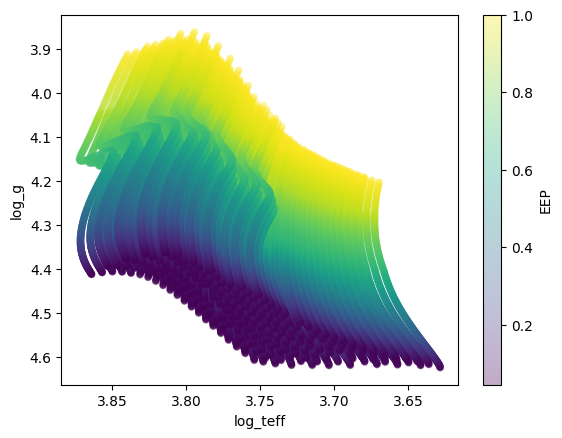

In [84]:
ax = df.plot(x="log_teff", y="log_g", c="EEP", kind="scatter", cmap="viridis", alpha=0.33)
ax.invert_xaxis()
ax.invert_yaxis()

In [85]:
input_cols = ["EEP", "initial_mass", "initial_feh"]
output_cols = ["log_age", "log_teff", "log_g"]

In [86]:
cols = input_cols + output_cols
train = df[cols].sample(frac=0.8)
test = df[cols].drop(train.index)

print('Train length = ', len(train))
print('Test length  = ', len(test))

Train length =  77498
Test length  =  16486


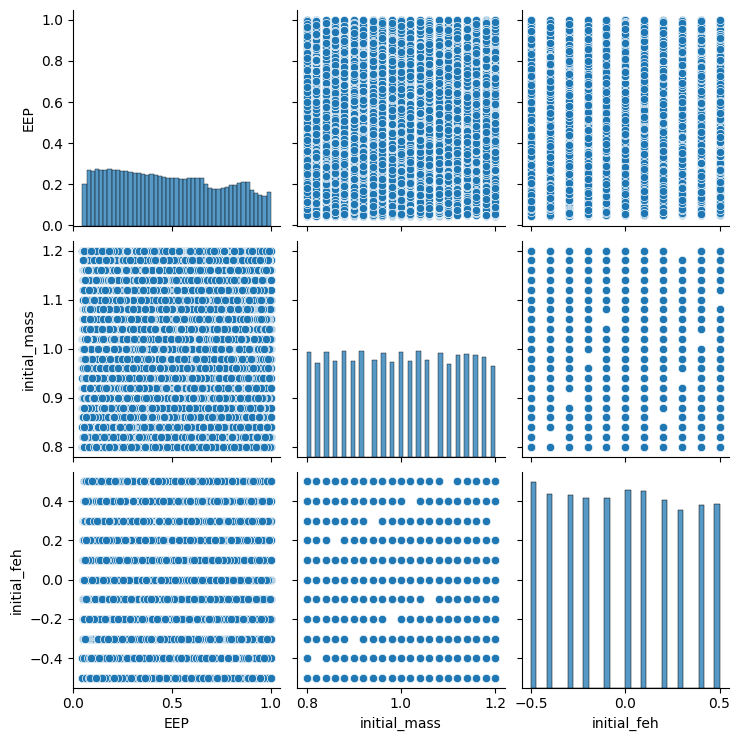

In [87]:
sns.pairplot(train, vars=input_cols);

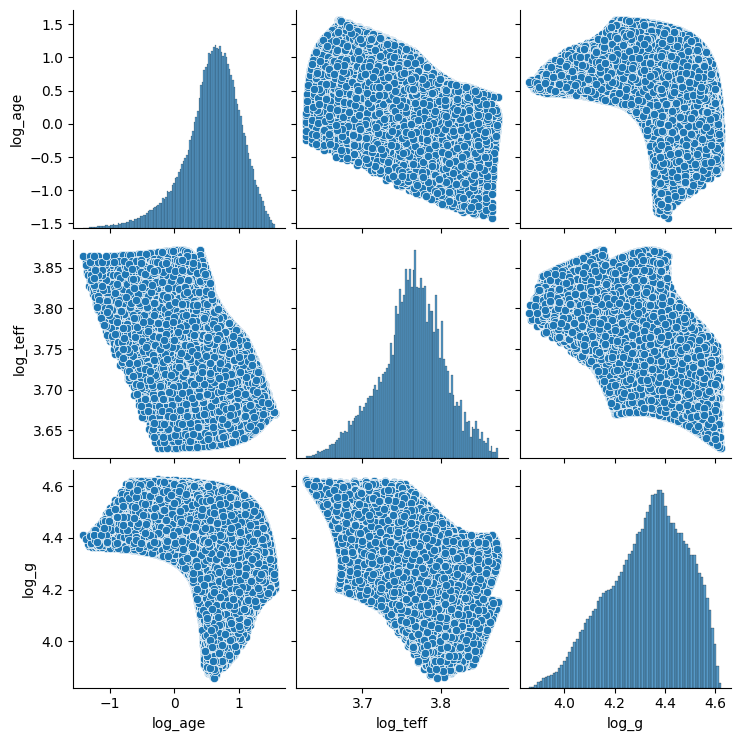

In [88]:
sns.pairplot(train, vars=output_cols);

In [89]:
input_normalizer = preprocessing.Normalization()
input_normalizer.adapt(train[input_cols].to_numpy())

print(input_normalizer.mean.numpy())
print(input_normalizer.variance.numpy())

[[ 0.48315036  0.9989062  -0.00932929]]
[[0.07202799 0.01458247 0.09998155]]


In [90]:
output_normalizer = preprocessing.Normalization()
output_normalizer.adapt(train[output_cols].to_numpy())

print(output_normalizer.mean.numpy())
print(output_normalizer.variance.numpy())

[[0.5930062 3.762909  4.330902 ]]
[[0.18937704 0.00173929 0.02348721]]


In [91]:
output_rescaler = preprocessing.Rescaling(
    scale=output_normalizer.variance**0.5, 
    offset=output_normalizer.mean
)

In [92]:
def build_model(num_neurons, num_hidden, activation='relu', reg=0):
    l2reg = keras.regularizers.L2(reg)
    hidden_layers = [
        layers.Dense(num_neurons, activation=activation, kernel_regularizer=l2reg) for layer in range(num_hidden)
    ]
    all_layers = [input_normalizer] + hidden_layers + [layers.Dense(len(output_cols)), output_rescaler]
    return keras.Sequential(all_layers)

In [93]:
model = build_model(64, 2)
model.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam(),
)
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 3)                7         
 ion)                                                            
                                                                 
 dense_88 (Dense)            (None, 64)                256       
                                                                 
 dense_89 (Dense)            (None, 64)                4160      
                                                                 
 dense_90 (Dense)            (None, 3)                 195       
                                                                 
 rescaling_1 (Rescaling)     (None, 3)                 0         
                                                                 
Total params: 4,618
Trainable params: 4,611
Non-trainable params: 7
___________________________________________________

In [94]:
epochs = 100
validation_split = 0.2
verbose = 0
batch_size = 2048
len(train)%batch_size

1722

In [95]:
%%time
history = model.fit(
    train[input_cols], train[output_cols],
    validation_split=validation_split,
    batch_size=batch_size,
    verbose=verbose, epochs=epochs,
)

CPU times: user 26.7 s, sys: 2.02 s, total: 28.7 s
Wall time: 22.9 s


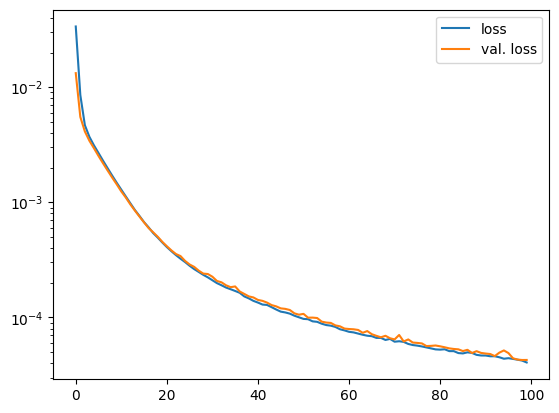

In [96]:
fig, ax = plt.subplots()

ax.plot(history.epoch, history.history['loss'], label='loss')
ax.plot(history.epoch, history.history['val_loss'], label='val. loss')

ax.set_yscale("log")
ax.legend();

In [ ]:
architectures = [(64, 4), (128, 2)]
histories = []

for arch in architectures:
    model = build_model(*arch)
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam())
    histories.append(model.fit(
      train[input_cols], train[output_cols],
      validation_split=validation_split,
      batch_size=batch_size,
      verbose=0, epochs=epochs,
    ))

fig, ax = plt.subplots()
for history, arch in zip(histories, architectures):
    ax.plot(history.epoch, history.history['val_loss'], label=arch)

ax.set_yscale('log')
ax.legend()
ax.set_title('validation loss')

In [ ]:
architectures = [(128, 4), (256, 2)]
histories = []

for arch in architectures:
    model = build_model(*arch)
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam())
    histories.append(model.fit(
      train[input_cols], train[output_cols],
      validation_split=validation_split,
      batch_size=batch_size,
      verbose=0, epochs=epochs,
    ))

fig, ax = plt.subplots()
for history, arch in zip(histories, architectures):
    ax.plot(history.epoch, history.history['val_loss'], label=arch)

ax.set_yscale('log')
ax.legend()
ax.set_title('validation loss')

In [ ]:
architectures = [(256, 4), (512, 2)]
histories = []

for arch in architectures:
    model = build_model(*arch)
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam())
    histories.append(model.fit(
      train[input_cols], train[output_cols],
      validation_split=validation_split,
      batch_size=batch_size,
      verbose=0, epochs=epochs,
    ))

fig, ax = plt.subplots()
for history, arch in zip(histories, architectures):
    ax.plot(history.epoch, history.history['val_loss'], label=arch)

ax.set_yscale('log')
ax.legend()
ax.set_title('validation loss')

In [ ]:
architectures = [(1024, 2), (2048, 2)]
histories = []

for arch in architectures:
    model = build_model(*arch)
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam())
    histories.append(model.fit(
      train[input_cols], train[output_cols],
      validation_split=validation_split,
      batch_size=batch_size,
      verbose=0, epochs=epochs,
    ))

fig, ax = plt.subplots()
for history, arch in zip(histories, architectures):
    ax.plot(history.epoch, history.history['val_loss'], label=arch)

ax.set_yscale('log')
ax.legend()
ax.set_title('validation loss')

Text(0.5, 1.0, 'validation loss')

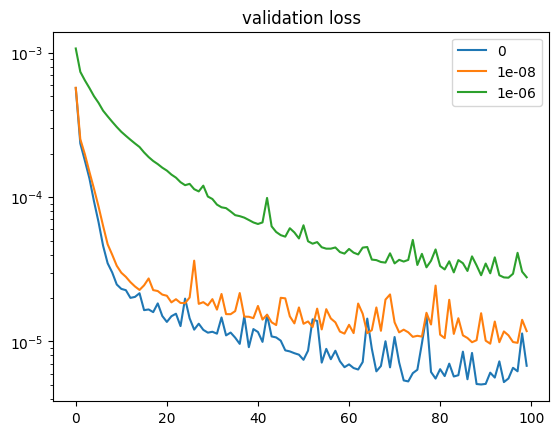

In [31]:
arch = (512, 2)
regs = [0, 1e-8, 1e-6]
histories = []

for reg in regs:
    model = build_model(*arch, reg=reg)
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam())
    histories.append(model.fit(
      train[input_cols], train[output_cols],
      validation_split=validation_split,
      batch_size=batch_size,
      verbose=0, epochs=epochs,
    ))

fig, ax = plt.subplots()
for history, reg in zip(histories, regs):
    ax.plot(history.epoch, history.history['val_loss'], label=reg)

plt.yscale('log')
plt.legend()
plt.title('validation loss')

In [32]:
model = build_model(512, 2, reg=0)

model.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam(),
)
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 3)                7         
 n)                                                              
                                                                 
 dense_85 (Dense)            (None, 512)               2048      
                                                                 
 dense_86 (Dense)            (None, 512)               262656    
                                                                 
 dense_87 (Dense)            (None, 2)                 1026      
                                                                 
 rescaling (Rescaling)       (None, 2)                 0         
                                                                 
Total params: 265,737
Trainable params: 265,730
Non-trainable params: 7
_______________________________________________

In [33]:
%%time
history = model.fit(
    train[input_cols], train[output_cols],
    validation_split=validation_split,
    batch_size=batch_size,
    verbose=verbose, epochs=1000,
)

CPU times: user 4min 8s, sys: 18 s, total: 4min 26s
Wall time: 3min 17s


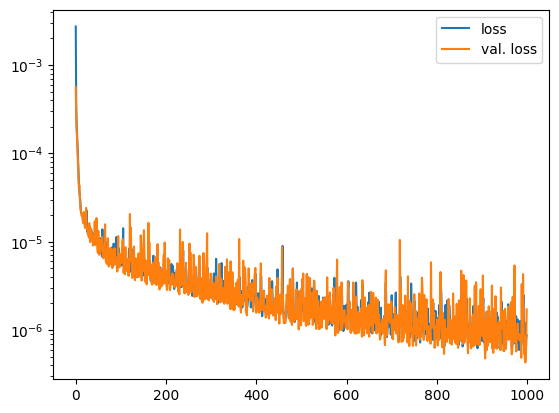

In [34]:
fig, ax = plt.subplots()

ax.plot(history.epoch, history.history['loss'], label='loss')
ax.plot(history.epoch, history.history['val_loss'], label='val. loss')

ax.set_yscale("log")
ax.legend();

## Test

In [38]:
pred = pd.DataFrame(
    model(test[input_cols]),
    columns=output_cols
)
pred.head()

,log_teff,log_g
0,3.748353,4.610955
1,3.748774,4.604581
2,3.749084,4.602526
3,3.749409,4.600330
4,3.749723,4.597530


In [41]:
log_err = test[output_cols].reset_index(drop=True) - pred
log_err.head()

,log_teff,log_g
0,-0.000470,0.001389
1,-0.000459,0.000480
2,-0.000601,0.000551
3,-0.000757,0.000882
4,-0.000796,0.000744


In [42]:
frac_err = 10**log_err

In [43]:
err = 10**test[output_cols].reset_index(drop=True) - 10**pred

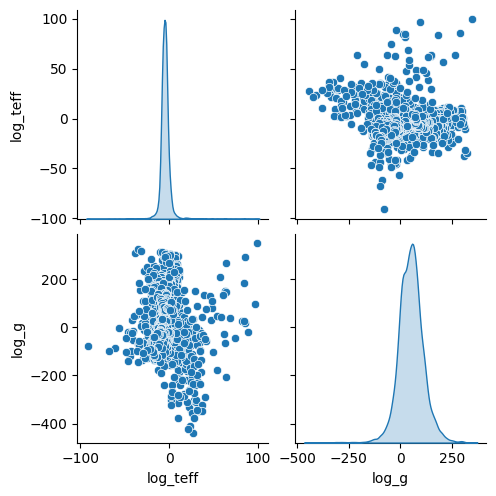

In [44]:
sns.pairplot(err, diag_kind='kde');

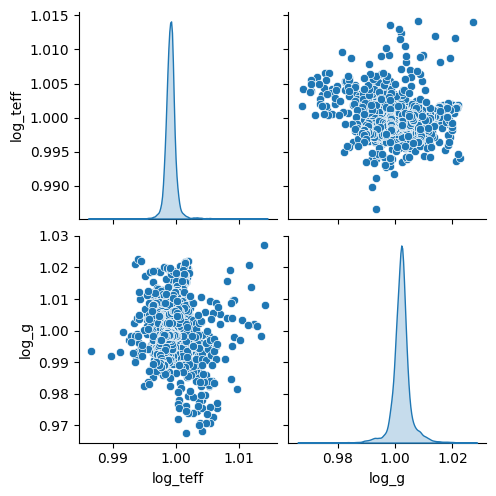

In [45]:
sns.pairplot(frac_err, diag_kind='kde');

In [160]:
from scipy.interpolate import LinearNDInterpolator, RegularGridInter

In [ ]:
mask = (df.frac_age > 0.015) & (df.center_h1 > 1e-12)

input_big = ["log_age", "initial_mass", "initial_feh", "initial_Yinit", "initial_MLT"]
output_big = ["log_teff", "log_g"]
cols_big = input_big + output_big
train_big = df.loc[mask, cols_big].sample(frac=0.8)
test_big = df.loc[mask, cols_big].drop(train_big.index)

interp_big = LinearNDInterpolator(train_big[input_big], train_big[output_big])

In [1]:
df.shape

NameError: name 'df' is not defined

In [ ]:
pred_big = pd.DataFrame(
    interp_big(test_big[output_big]),
    columns=output_big
)
pred_big.head()

In [161]:
interp = LinearNDInterpolator(train[input_cols], train[output_cols])

In [162]:
pred_interp = pd.DataFrame(
    interp(test[input_cols]),
    columns=output_cols
)
pred_interp.head()

,log_teff,log_g
0,3.748764,4.600004
1,3.749203,4.595431
2,3.749313,4.594297
3,3.749368,4.593735
4,3.749863,4.588695


In [163]:
err_interp = test[output_cols].reset_index(drop=True) - pred_interp
err_interp.head()

,log_teff,log_g
0,-1.248541e-06,0.000011
1,-6.924373e-07,0.000009
2,-1.655967e-06,0.000016
3,-1.626549e-06,0.000015
4,-6.600761e-07,0.000006


In [174]:
error = pd.concat(
    {"NN": err, "Interp": err_interp},
    names=["method"]
).reset_index(level=0).reset_index(drop=True)
error.head()

,method,log_teff,log_g
0,NN,-0.000368,-0.001732
1,NN,-0.000353,-0.001342
2,NN,-0.000434,-0.001066
3,NN,-0.000470,-0.000957
4,NN,-0.000695,-0.000701


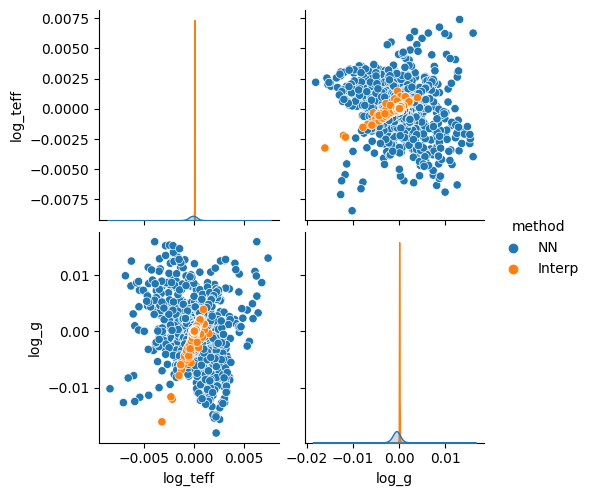

In [175]:
sns.pairplot(error, hue="method", diag_kind="kde", diag_kws=dict(common_norm=False));

In [94]:
model_tf = tf.function(model, jit_compile=True)

In [90]:
%%timeit
interp(test[input_cols].iloc[0])

449 µs ± 3.96 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [91]:
%%timeit
model(test[input_cols].iloc[0])

3.02 ms ± 275 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [96]:
%%timeit
model_tf(test[input_cols].iloc[0])

1.07 ms ± 38.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [97]:
%%timeit
interp(test[input_cols])

58.9 ms ± 438 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [98]:
%%timeit
model(test[input_cols])

3.22 ms ± 328 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [100]:
%%timeit
model_tf(test[input_cols])

1.85 ms ± 263 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [104]:
df.columns

Index(['index', 'dirname', 'filename', 'model_number', 'evol_stage',
       'initial_mass', 'initial_Yinit', 'initial_Zinit', 'initial_feh',
       'initial_MLT', 'initial_fov', 'star_mass', 'star_age', 'ms_age',
       'frac_age', 'effective_T', 'luminosity', 'radius', 'log_g',
       'surface_h1', 'surface_he4', 'surface_Z', 'star_feh', 'center_h1',
       'center_he4', 'log_center_T', 'log_center_Rho', 'he_core_mass',
       'delta_nu', 'delta_Pg', 'nu_max', 'acoustic_cutoff', 'nu_0_1', 'nu_0_2',
       'nu_0_3', 'nu_0_4', 'nu_0_5', 'nu_0_6', 'nu_0_7', 'nu_0_8', 'nu_0_9',
       'nu_0_10', 'nu_0_11', 'nu_0_12', 'nu_0_13', 'nu_0_14', 'nu_0_15',
       'nu_0_16', 'nu_0_17', 'nu_0_18', 'nu_0_19', 'nu_0_20', 'nu_0_21',
       'nu_0_22', 'nu_0_23', 'nu_0_24', 'nu_0_25', 'nu_0_26', 'nu_0_27',
       'nu_0_28', 'nu_0_29', 'nu_0_30', 'nu_0_31', 'nu_0_32', 'nu_0_33',
       'nu_0_34', 'nu_0_35', 'nu_0_36', 'nu_0_37', 'nu_0_38', 'nu_0_39',
       'nu_0_40', 'log_age', 'log_kron', 'kron', 'log

In [137]:
train_big = df.loc[train.index]
train_big = train_big.loc[train_big["nu_0_20"] != 0.0]

In [138]:
test_big = df.loc[test.index]
test_big = test_big.loc[test_big["nu_0_20"] != 0.0]

In [141]:
%%time
big_cols = output_cols + [f"nu_0_{i}" for i in range(5, 35)]
interp_big = LinearNDInterpolator(train_big[input_cols], train_big[big_cols])

CPU times: user 25.8 s, sys: 0 ns, total: 25.8 s
Wall time: 25.8 s


In [142]:
%%timeit
interp_big(test[input_cols].iloc[:100])

811 µs ± 232 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [143]:
pred_big = pd.DataFrame(
    interp_big(test_big[input_cols]),
    columns=big_cols
)

In [151]:
err_big = test_big[big_cols].reset_index(drop=True) - pred_big

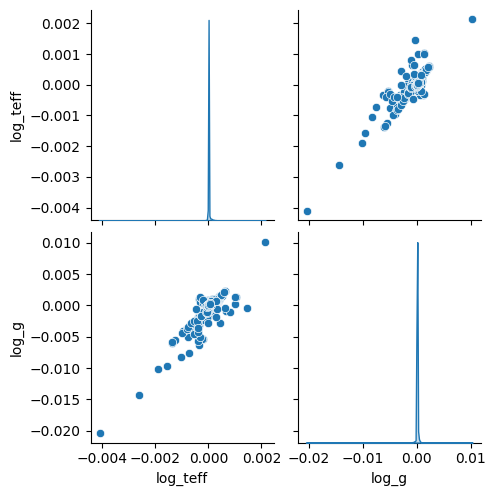

In [152]:
sns.pairplot(err_big, vars=output_cols, diag_kind='kde');

In [153]:
err_big

,log_teff,log_g,nu_0_5,nu_0_6,nu_0_7,nu_0_8,nu_0_9,nu_0_10,nu_0_11,nu_0_12,...,nu_0_25,nu_0_26,nu_0_27,nu_0_28,nu_0_29,nu_0_30,nu_0_31,nu_0_32,nu_0_33,nu_0_34
0,-1.248541e-06,0.000011,0.019651,0.023518,0.027257,0.030945,0.034729,0.038322,0.042359,0.045784,...,0.089419,0.092601,0.095842,0.099278,0.102386,0.105974,0.109043,0.112638,0.115883,0.119447
1,-6.924373e-07,0.000009,0.016763,0.019912,0.023049,0.026337,0.029242,0.032809,0.035624,0.039172,...,0.075450,0.078865,0.081431,0.083886,0.087487,0.089120,0.093301,0.095015,0.098674,0.101470
2,-1.655967e-06,0.000016,0.028298,0.033868,0.039294,0.044585,0.050131,0.055231,0.061039,0.065988,...,0.128767,0.133292,0.138055,0.142968,0.147462,0.152604,0.157126,0.162383,0.166927,0.172330
3,-1.626549e-06,0.000015,0.027899,0.033372,0.038712,0.043918,0.049371,0.054414,0.060114,0.065029,...,0.126812,0.131321,0.135961,0.140801,0.145220,0.150222,0.154700,0.159747,0.164206,0.169314
4,-6.600761e-07,0.000006,0.011478,0.013765,0.015984,0.018089,0.020397,0.022447,0.024779,0.026827,...,0.052361,0.054144,0.056102,0.058117,0.059873,0.062072,0.063832,0.065960,0.067799,0.069944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17197,-9.068146e-06,-0.000046,-0.043650,-0.050960,-0.058231,-0.064864,-0.071116,-0.077483,-0.084025,-0.090666,...,-0.178789,-0.185716,-0.192977,-0.199710,-0.206105,-0.213319,-0.222819,-0.236845,-0.241417,-0.245460
17198,1.827179e-06,0.000017,0.007549,0.008345,0.008944,0.009749,0.010775,0.011850,0.012936,0.014120,...,0.029764,0.031095,0.032932,0.034889,0.036934,0.037046,0.033433,0.034674,0.036449,0.038578
17199,2.649992e-05,0.000208,0.093745,0.103845,0.111766,0.121998,0.133779,0.146592,0.159642,0.172650,...,0.360219,0.375991,0.398593,0.423595,0.444001,0.433770,0.407234,0.426387,0.448173,0.471213
17200,6.771227e-05,0.000308,0.130071,0.142307,0.152716,0.165689,0.180471,0.195385,0.210651,0.226111,...,0.483255,0.503498,0.521237,0.526664,0.525543,0.540115,0.569135,0.595130,0.615205,0.628544


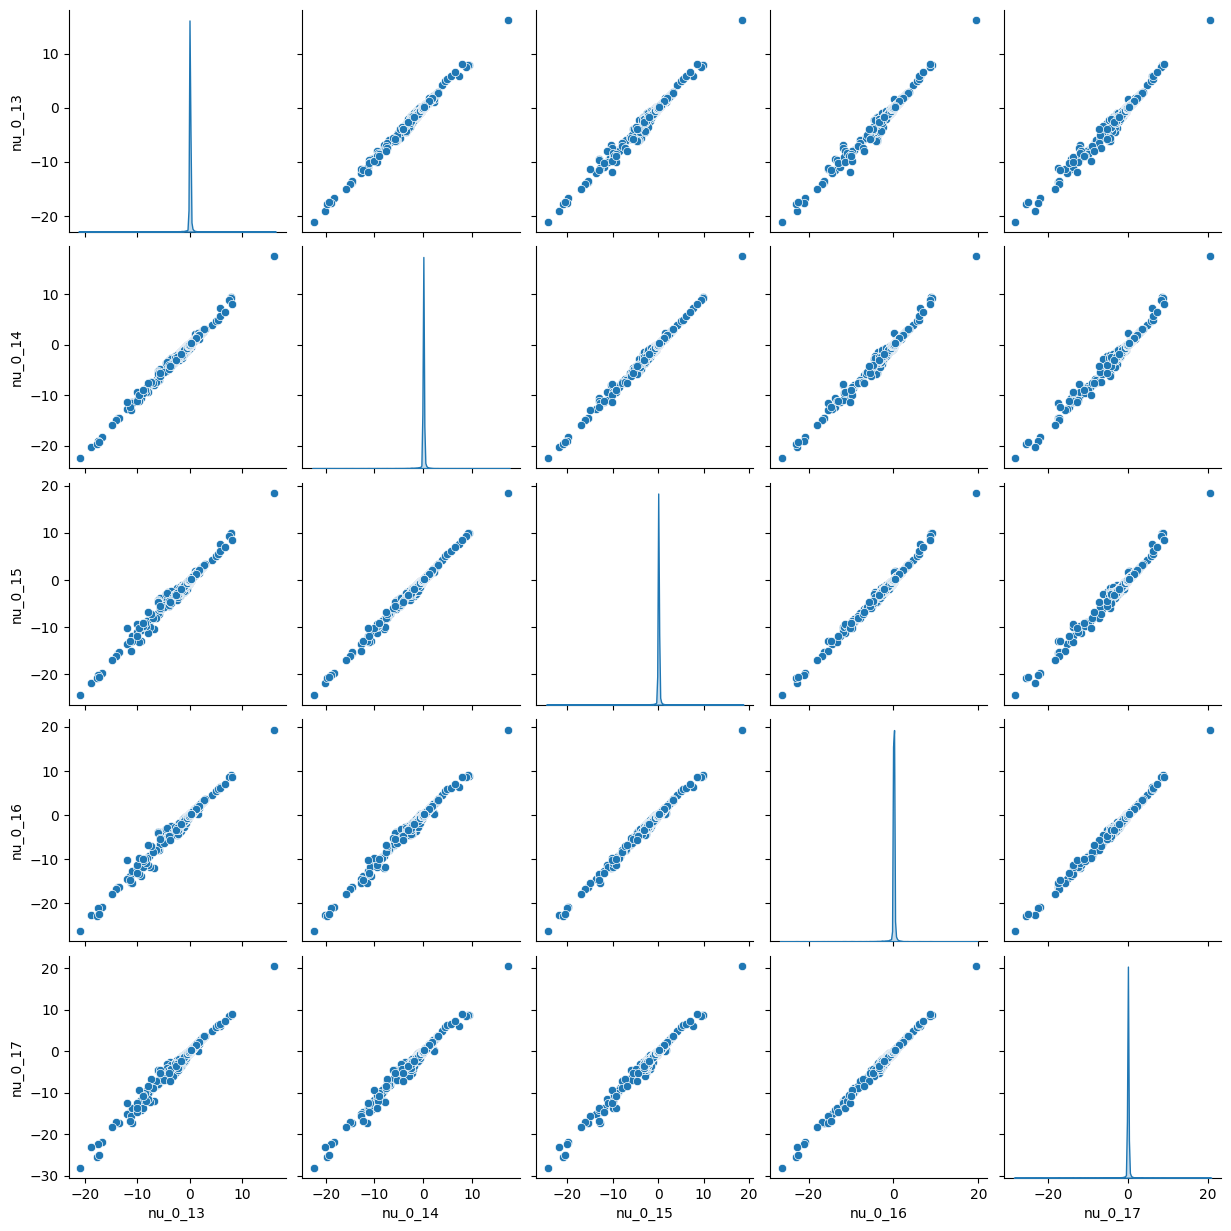

In [154]:
sns.pairplot(err_big, vars=big_cols[10:15], diag_kind='kde');